In [1]:
import gym
import torch

from src.Learner.AWAC import AWAC
from src.Learner.DQN import DQN
from src.Learner.Random import DiscreteRandomAgent
from src.nn.MLP import MLP
from src.utils.memory import ReplayMemory
from src.utils.train_utils import prepare_training_inputs

import matplotlib.pyplot as plt

c:\Users\Go\miniconda3\envs\pro1\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)


fitting [1000] / [5000]
fitting [2000] / [5000]
fitting [3000] / [5000]
fitting [4000] / [5000]


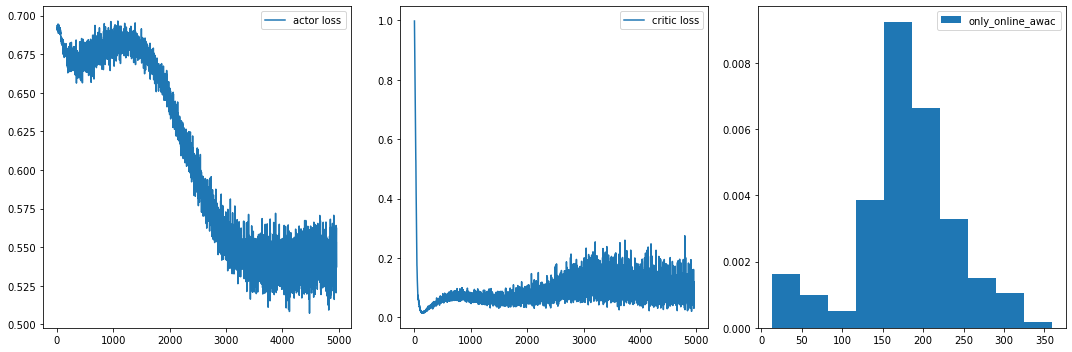

In [2]:
gamma = 0.9
memory_size = 500000
qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)
env = gym.make('CartPole-v1')
memory = ReplayMemory(memory_size)

fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'
agent.to(fit_device)


# 메모리에 online data 수집하는 과정
online_budget = 5000
batch_size = 1000
online_awac_cum_rs = []

online_critic_losses = []
online_actor_losses = []
for n_epi in range(online_budget):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)
        
        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)
        
        s = ns
        cum_r += 1
        if done:
            online_awac_cum_rs.append(cum_r)
            break
    
    # 데이터를 수집한 후 모델 업데이트
    if len(memory) >= batch_size:
        if n_epi%batch_size ==0:
            print("fitting [{}] / [{}]".format(n_epi, online_budget))
        
        #전체데이터를 사용하는 것이 아니라 샘플링을 통해 사용(offline data도 포함되어 있는 상태)
        sampled_exps = memory.sample(batch_size)
        # s, a, r, ns, done = prepare_training_inputs(sampled_exps,device=fit_device)  

        # critic_loss = agent.update_critic(s,a,r,ns,done)
        # actor_loss = agent.update_actor(s,a)

        _s, _a, _r, _ns, _done = prepare_training_inputs(sampled_exps, device=fit_device)
        agent.to(fit_device)
        critic_loss = agent.update_critic(_s,_a,_r,_ns,_done)
        actor_loss = agent.update_actor(_s,_a)
        
        online_critic_losses.append(critic_loss.detach())
        online_actor_losses.append(actor_loss.detach())   

        agent.to('cpu')

only_online_awac_cum_rs = []
test = 500
for n_epi in range(test):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)

        s = ns
        cum_r += 1
        if done:
            only_online_awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(online_actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(online_critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(only_online_awac_cum_rs, density=True, label='only_online_awac')
axes[2].legend()
fig.tight_layout()

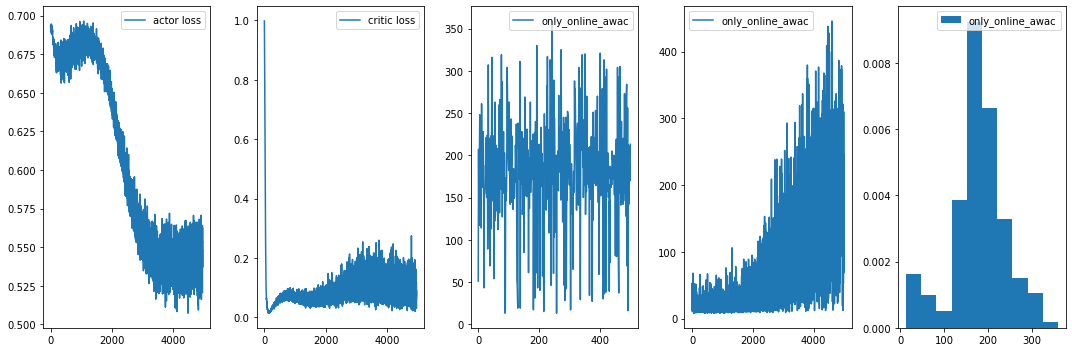

In [7]:
fig, axes = plt.subplots(1,5, figsize=(15,5))
axes[0].plot(online_actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(online_critic_losses, label='critic loss')
axes[1].legend()
axes[2].plot(only_online_awac_cum_rs, label='only_online_awac')
axes[2].legend()
axes[3].plot(online_awac_cum_rs,label='only_online_awac')
axes[3].legend()
axes[4].hist(only_online_awac_cum_rs, density=True, label='only_online_awac')
axes[4].legend()
fig.tight_layout()

fitting [1000] / [5000]
fitting [2000] / [5000]
fitting [3000] / [5000]
fitting [4000] / [5000]


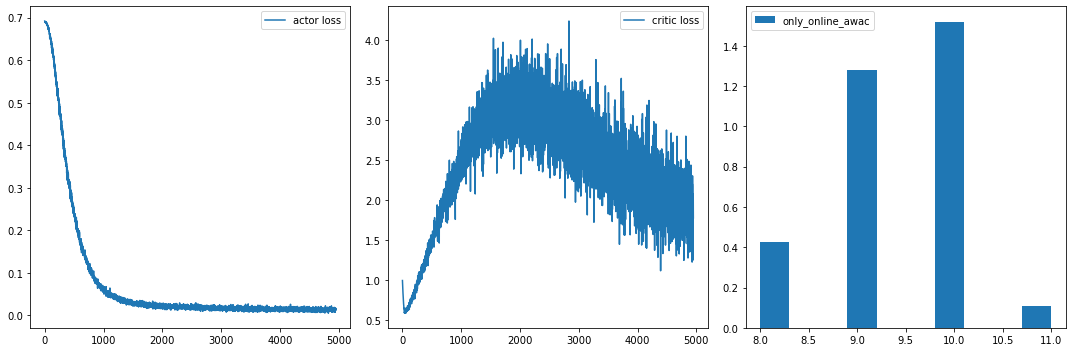

In [4]:
gamma = 0.9
memory_size = 500000
qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)
env = gym.make('CartPole-v1')
memory = ReplayMemory(memory_size)

fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'
agent.to(fit_device)


# 메모리에 online data 수집하는 과정
online_budget = 5000
batch_size = 1000
online_awac_cum_rs = []

online_critic_losses = []
online_actor_losses = []
for n_epi in range(online_budget):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)
        
        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)
        
        s = ns
        cum_r += 1
        if done:
            online_awac_cum_rs.append(cum_r)
            break
    
    # 데이터를 수집한 후 모델 업데이트
    if len(memory) >= batch_size:
        if n_epi%batch_size ==0:
            print("fitting [{}] / [{}]".format(n_epi, online_budget))
        
        #전체데이터를 사용하는 것이 아니라 샘플링을 통해 사용(offline data도 포함되어 있는 상태)
        sampled_exps = memory.sample(batch_size)
        # s, a, r, ns, done = prepare_training_inputs(sampled_exps,device=fit_device)  

        # critic_loss = agent.update_critic(s,a,r,ns,done)
        # actor_loss = agent.update_actor(s,a)

        _s, _a, _r, _ns, _done = prepare_training_inputs(sampled_exps, device=fit_device)
        agent.to(fit_device)
        critic_loss = agent.update_critic(_s,_a,_r,_ns,_done)
        actor_loss = agent.update_actor(_s,_a)
        
        online_critic_losses.append(critic_loss.detach())
        online_actor_losses.append(actor_loss.detach())   

        agent.to('cpu')

only_online_awac_cum_rs = []
test = 500
for n_epi in range(test):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)

        s = ns
        cum_r += 1
        if done:
            only_online_awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(online_actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(online_critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(only_online_awac_cum_rs, density=True, label='only_online_awac')
axes[2].legend()
fig.tight_layout()

fitting [1000] / [5000]
fitting [2000] / [5000]
fitting [3000] / [5000]
fitting [4000] / [5000]


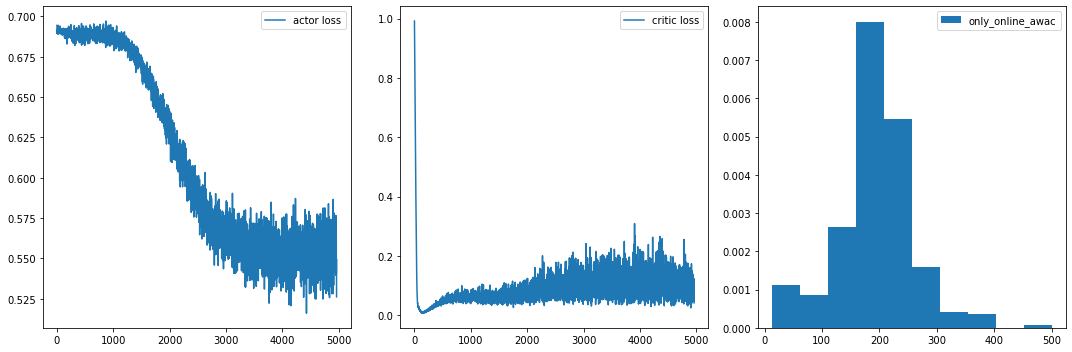

In [5]:
gamma = 0.9
memory_size = 500000
qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)
env = gym.make('CartPole-v1')
memory = ReplayMemory(memory_size)

fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'
agent.to(fit_device)


# 메모리에 online data 수집하는 과정
online_budget = 5000
batch_size = 1000
online_awac_cum_rs = []

online_critic_losses = []
online_actor_losses = []
for n_epi in range(online_budget):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)
        
        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)
        
        s = ns
        cum_r += 1
        if done:
            online_awac_cum_rs.append(cum_r)
            break
    
    # 데이터를 수집한 후 모델 업데이트
    if len(memory) >= batch_size:
        if n_epi%batch_size ==0:
            print("fitting [{}] / [{}]".format(n_epi, online_budget))
        
        #전체데이터를 사용하는 것이 아니라 샘플링을 통해 사용(offline data도 포함되어 있는 상태)
        sampled_exps = memory.sample(batch_size)
        # s, a, r, ns, done = prepare_training_inputs(sampled_exps,device=fit_device)  

        # critic_loss = agent.update_critic(s,a,r,ns,done)
        # actor_loss = agent.update_actor(s,a)

        _s, _a, _r, _ns, _done = prepare_training_inputs(sampled_exps, device=fit_device)
        agent.to(fit_device)
        critic_loss = agent.update_critic(_s,_a,_r,_ns,_done)
        actor_loss = agent.update_actor(_s,_a)
        
        online_critic_losses.append(critic_loss.detach())
        online_actor_losses.append(actor_loss.detach())   

        agent.to('cpu')

only_online_awac_cum_rs = []
test = 500
for n_epi in range(test):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)

        s = ns
        cum_r += 1
        if done:
            only_online_awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(online_actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(online_critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(only_online_awac_cum_rs, density=True, label='only_online_awac')
axes[2].legend()
fig.tight_layout()

fitting [1000] / [5000]
fitting [2000] / [5000]
fitting [3000] / [5000]
fitting [4000] / [5000]


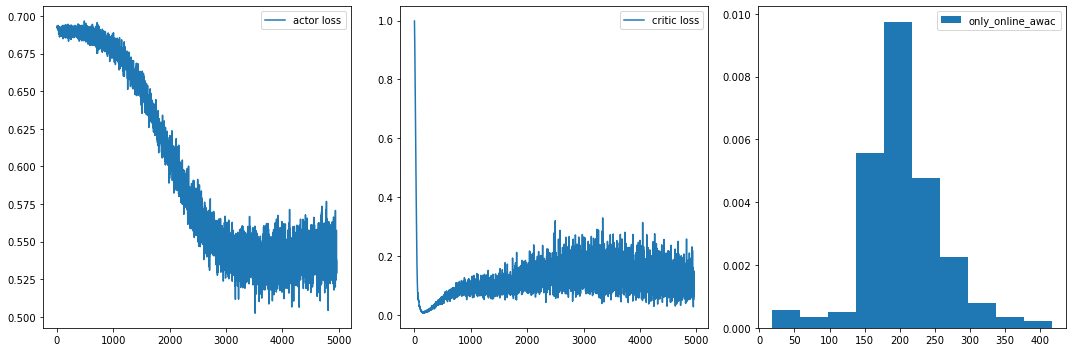

In [6]:
gamma = 0.9
memory_size = 500000
qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)
env = gym.make('CartPole-v1')
memory = ReplayMemory(memory_size)

fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'
agent.to(fit_device)


# 메모리에 online data 수집하는 과정
online_budget = 5000
batch_size = 1000
online_awac_cum_rs = []

online_critic_losses = []
online_actor_losses = []
for n_epi in range(online_budget):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)
        
        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)
        
        s = ns
        cum_r += 1
        if done:
            online_awac_cum_rs.append(cum_r)
            break
    
    # 데이터를 수집한 후 모델 업데이트
    if len(memory) >= batch_size:
        if n_epi%batch_size ==0:
            print("fitting [{}] / [{}]".format(n_epi, online_budget))
        
        #전체데이터를 사용하는 것이 아니라 샘플링을 통해 사용(offline data도 포함되어 있는 상태)
        sampled_exps = memory.sample(batch_size)
        # s, a, r, ns, done = prepare_training_inputs(sampled_exps,device=fit_device)  

        # critic_loss = agent.update_critic(s,a,r,ns,done)
        # actor_loss = agent.update_actor(s,a)

        _s, _a, _r, _ns, _done = prepare_training_inputs(sampled_exps, device=fit_device)
        agent.to(fit_device)
        critic_loss = agent.update_critic(_s,_a,_r,_ns,_done)
        actor_loss = agent.update_actor(_s,_a)
        
        online_critic_losses.append(critic_loss.detach())
        online_actor_losses.append(actor_loss.detach())   

        agent.to('cpu')

only_online_awac_cum_rs = []
test = 500
for n_epi in range(test):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)

        s = ns
        cum_r += 1
        if done:
            only_online_awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(online_actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(online_critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(only_online_awac_cum_rs, density=True, label='only_online_awac')
axes[2].legend()
fig.tight_layout()

fitting [1000] / [5000]
fitting [2000] / [5000]
fitting [3000] / [5000]
fitting [4000] / [5000]


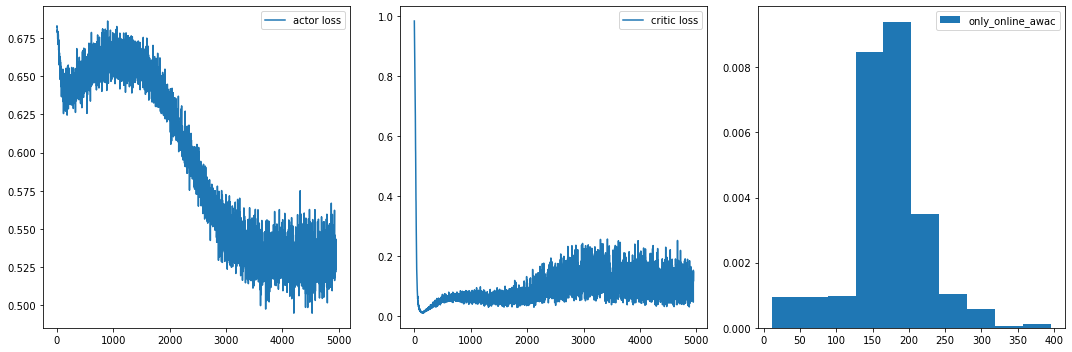

In [7]:
gamma = 0.9
memory_size = 500000
qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)
env = gym.make('CartPole-v1')
memory = ReplayMemory(memory_size)

fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'
agent.to(fit_device)


# 메모리에 online data 수집하는 과정
online_budget = 5000
batch_size = 1000
online_awac_cum_rs = []

online_critic_losses = []
online_actor_losses = []
for n_epi in range(online_budget):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)
        
        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)
        
        s = ns
        cum_r += 1
        if done:
            online_awac_cum_rs.append(cum_r)
            break
    
    # 데이터를 수집한 후 모델 업데이트
    if len(memory) >= batch_size:
        if n_epi%batch_size ==0:
            print("fitting [{}] / [{}]".format(n_epi, online_budget))
        
        #전체데이터를 사용하는 것이 아니라 샘플링을 통해 사용(offline data도 포함되어 있는 상태)
        sampled_exps = memory.sample(batch_size)
        # s, a, r, ns, done = prepare_training_inputs(sampled_exps,device=fit_device)  

        # critic_loss = agent.update_critic(s,a,r,ns,done)
        # actor_loss = agent.update_actor(s,a)

        _s, _a, _r, _ns, _done = prepare_training_inputs(sampled_exps, device=fit_device)
        agent.to(fit_device)
        critic_loss = agent.update_critic(_s,_a,_r,_ns,_done)
        actor_loss = agent.update_actor(_s,_a)
        
        online_critic_losses.append(critic_loss.detach())
        online_actor_losses.append(actor_loss.detach())   

        agent.to('cpu')

only_online_awac_cum_rs = []
test = 500
for n_epi in range(test):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)

        s = ns
        cum_r += 1
        if done:
            only_online_awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(online_actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(online_critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(only_online_awac_cum_rs, density=True, label='only_online_awac')
axes[2].legend()
fig.tight_layout()

fitting [1000] / [5000]
fitting [2000] / [5000]
fitting [3000] / [5000]
fitting [4000] / [5000]


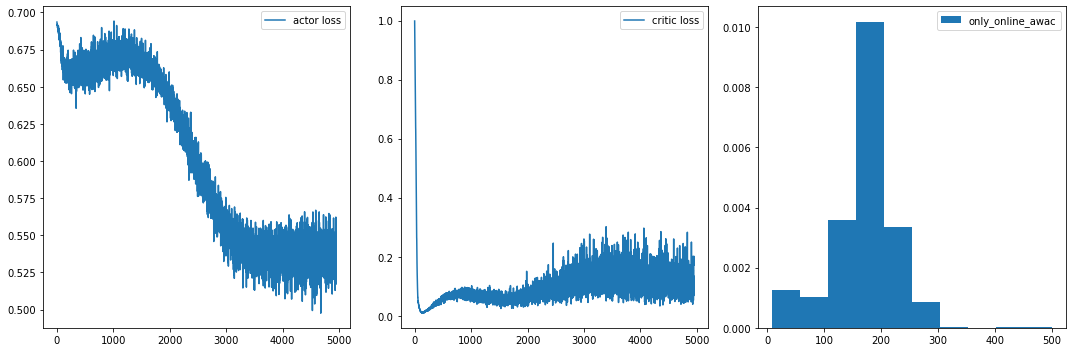

In [8]:
gamma = 0.9
memory_size = 500000
qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)
env = gym.make('CartPole-v1')
memory = ReplayMemory(memory_size)

fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'
agent.to(fit_device)


# 메모리에 online data 수집하는 과정
online_budget = 5000
batch_size = 1000
online_awac_cum_rs = []

online_critic_losses = []
online_actor_losses = []
for n_epi in range(online_budget):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)
        
        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)
        
        s = ns
        cum_r += 1
        if done:
            online_awac_cum_rs.append(cum_r)
            break
    
    # 데이터를 수집한 후 모델 업데이트
    if len(memory) >= batch_size:
        if n_epi%batch_size ==0:
            print("fitting [{}] / [{}]".format(n_epi, online_budget))
        
        #전체데이터를 사용하는 것이 아니라 샘플링을 통해 사용(offline data도 포함되어 있는 상태)
        sampled_exps = memory.sample(batch_size)
        # s, a, r, ns, done = prepare_training_inputs(sampled_exps,device=fit_device)  

        # critic_loss = agent.update_critic(s,a,r,ns,done)
        # actor_loss = agent.update_actor(s,a)

        _s, _a, _r, _ns, _done = prepare_training_inputs(sampled_exps, device=fit_device)
        agent.to(fit_device)
        critic_loss = agent.update_critic(_s,_a,_r,_ns,_done)
        actor_loss = agent.update_actor(_s,_a)
        
        online_critic_losses.append(critic_loss.detach())
        online_actor_losses.append(actor_loss.detach())   

        agent.to('cpu')

only_online_awac_cum_rs = []
test = 500
for n_epi in range(test):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)

        s = ns
        cum_r += 1
        if done:
            only_online_awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(online_actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(online_critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(only_online_awac_cum_rs, density=True, label='only_online_awac')
axes[2].legend()
fig.tight_layout()